<a href="https://colab.research.google.com/github/aaatou123/Tor_Portfolio/blob/master/Sentiment_Analysis_%E0%B8%A0%E0%B8%B2%E0%B8%A9%E0%B8%B2%E0%B9%84%E0%B8%97%E0%B8%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pythainlp
!pip install stop_words
!pip install deepcut

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample 


import deepcut
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import wordnet
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
from pythainlp.corpus import thai_stopwords


from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, GRU
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

import pickle

**Read Dataset**

In [ ]:
file_pos = '/content/drive/My Drive/datasets/wisesight-sentiment-master/pos.txt'
file_neg = '/content/drive/My Drive/datasets/wisesight-sentiment-master/neg.txt'
file_neu = '/content/drive/My Drive/datasets/wisesight-sentiment-master/neu.txt'
with codecs.open(file_pos, 'r', "utf-8") as f:
  lines = f.readlines()
listpos=[e.strip() for e in lines]
del lines
f.close()
with codecs.open(file_neg, 'r', "utf-8") as f:
  lines = f.readlines()
listneg=[e.strip() for e in lines]
del lines
f.close()
pos1=['pos']*len(listpos)
neg1=['neg']*len(listneg)
training_data = list(zip(listpos,pos1)) + list(zip(listneg,neg1))
df_sentiment = pd.DataFrame(data=training_data, columns=['SentimentText', 'Sentiment'])
df_sentiment = df_sentiment.sample(frac = 1) 
df_sentiment.head()

,SentimentText,Sentiment
653,ยอดเยี่ยม,pos
9179,บอกละ นานมาก คือกูก็ไม่รู้อะว่าจะทำยังไง เครีย...,neg
10270,ปกติซื้อเดอะเฟสช็อปน้อยมากส่วนใหญ่ก็อินนิสฟรีง...,neg
3042,ชุดไหนดี เพื่อนบ้านในอณาคตสนใจม้ายยยย,pos
921,ไปๆ ใด้เฮงๆ,pos


In [ ]:
df_sentiment['word'] = df_sentiment['SentimentText'].apply(word_tokenize)
df_sentiment['length'] = df_sentiment['SentimentText'].apply(word_tokenize).apply(len)
df_sentiment.head()
df_sentiment.length.value_counts()

3      630
6      611
4      610
7      574
5      567
      ... 
140      1
180      1
188      1
196      1
219      1
Name: length, Length: 216, dtype: int64

### **Train model with traditional ML**

Cleaning and Preprocessing data

In [ ]:
nltk.download('words')
th_stop = tuple(thai_stopwords())
en_stop = tuple(get_stop_words('en'))
p_stemmer = PorterStemmer()
def split_word(text):
            
    
    tokens = deepcut.tokenize(text)
    
    tokens = [i for i in tokens if not i in th_stop and not i in en_stop]
    

    tokens = [p_stemmer.stem(i) for i in tokens]
    

    tokens_temp=[]
    for i in tokens:
        w_syn = wordnet.synsets(i)
        if (len(w_syn)>0) and (len(w_syn[0].lemma_names('tha'))>0):
            tokens_temp.append(w_syn[0].lemma_names('tha')[0])
        else:
            tokens_temp.append(i)
    
    tokens = tokens_temp

    tokens = [i for i in tokens if not i.isnumeric()]
  
    tokens = [i for i in tokens if not ' ' in i]

    return tokens

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
#Tokenize Text and clean data
tokens_list = [split_word(txt) for txt in df_sentiment['SentimentText']]
tokens_list_j = [','.join(tkn) for tkn in tokens_list]

#Vectorization
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','))
tvec.fit(tokens_list_j)
t_feat = tvec.transform(tokens_list_j)
text_transformed = pd.DataFrame(t_feat.toarray(), columns=tvec.get_feature_names())

#Label Encoder
le = LabelEncoder()
le.fit(df_sentiment.Sentiment)
y = le.transform(df_sentiment.Sentiment)
X = text_transformed

#Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2475)

Train model

In [ ]:
#LogisticRegression
log_reg = LogisticRegression(C=6).fit(X_train, y_train)
print('Accuracy LogisticRegression on the train set: ', log_reg.score(X_train, y_train))
print('Accuracy LogisticRegression on the test set: ', log_reg.score(X_test, y_test))

#MultinomialNB
MNB = MultinomialNB().fit(X_train, y_train)
print('Accuracy MultinomialNB on the train set: ', MNB.score(X_train, y_train))
print('Accuracy MultinomialNB on the test set: ', MNB.score(X_test, y_test))

Accuracy LogisticRegression on the train set:  0.9474194591100097
Accuracy LogisticRegression on the test set:  0.8043946574752262
Accuracy MultinomialNB on the train set:  0.8526020902919944
Accuracy MultinomialNB on the test set:  0.7544161999138302


# **Train model with RNN**

Text Preprocessing

In [ ]:
def split_word_rnn(text):
            
    
    tokens = word_tokenize(text,engine='newmm')
    
    tokens = [i for i in tokens if not i in th_stop]

    tokens_temp=[]
    for i in tokens:
        w_syn = wordnet.synsets(i)
        if (len(w_syn)>0) and (len(w_syn[0].lemma_names('tha'))>0):
            tokens_temp.append(w_syn[0].lemma_names('tha')[0])
        else:
            tokens_temp.append(i)
    
    tokens = tokens_temp
    
    tokens = [i for i in tokens if not i.isnumeric()]
    
    tokens = [i for i in tokens if not ' ' in i]

    return tokens

In [ ]:
#clean data
tokens_rnn = [split_word_rnn(txt) for txt in df_sentiment['SentimentText']]
tokens_rnn_j = [','.join(tkn) for tkn in tokens_list]

#Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens_list_j)
x_rnn = pad_sequences(tokenizer.texts_to_sequences(tokens_list_j), maxlen=600)

#vocabulary size
vocab_size = len(tokenizer.word_index) + 1

#Split train and test
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(x_rnn, y, test_size=0.2, random_state=2475)

Build Model

In [ ]:
early_stopping_monitor = EarlyStopping(patience=1, monitor='val_loss')

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=600, trainable=True))
model.add(Dropout(0.5))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Compile model

In [ ]:
train_model2 = model.fit(X_train_rnn, y_train_rnn,
                    batch_size=1024,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1,
                    callbacks= [early_stopping_monitor]
                    )

Epoch 1/10
9/9 [==============================] - 21s 2s/step - loss: 0.6838 - accuracy: 0.5995 - val_loss: 0.6525 - val_accuracy: 0.7212
Epoch 2/10
9/9 [==============================] - 19s 2s/step - loss: 0.6344 - accuracy: 0.6979 - val_loss: 0.5904 - val_accuracy: 0.7040
Epoch 3/10
9/9 [==============================] - 19s 2s/step - loss: 0.5775 - accuracy: 0.7026 - val_loss: 0.5639 - val_accuracy: 0.7051
Epoch 4/10
9/9 [==============================] - 19s 2s/step - loss: 0.5398 - accuracy: 0.7339 - val_loss: 0.5384 - val_accuracy: 0.7481
Epoch 5/10
9/9 [==============================] - 19s 2s/step - loss: 0.4973 - accuracy: 0.7705 - val_loss: 0.5089 - val_accuracy: 0.7492
Epoch 6/10
9/9 [==============================] - 19s 2s/step - loss: 0.4421 - accuracy: 0.7961 - val_loss: 0.4847 - val_accuracy: 0.7707
Epoch 7/10
9/9 [==============================] - 19s 2s/step - loss: 0.3842 - accuracy: 0.8348 - val_loss: 0.4645 - val_accuracy: 0.7815
Epoch 8/10
9/9 [==================

In [ ]:
def decode_sentiment(score):
  if score >= 0.5:
    label = 1
  else:
    label = 0
  return label

Text(69.0, 0.5, 'True label')

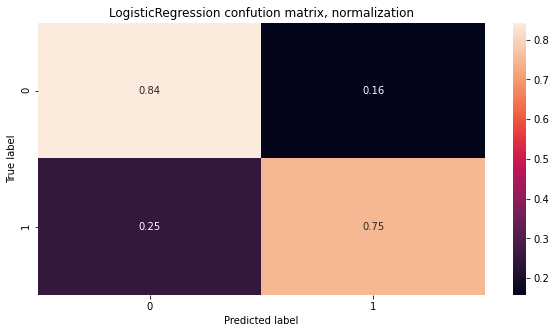

In [ ]:
y_pred_log = log_reg.predict(X_test)
y_pred_log = [decode_sentiment(score) for score in y_pred_log]
plt.figure(figsize=(10, 5))
cf_matrix_log = confusion_matrix(y_test, y_pred_log, normalize='true')
sns.heatmap(cf_matrix_log, annot=True)
plt.title('LogisticRegression confution matrix, normalization')
plt.xlabel('Predicted label')
plt.ylabel('True label')

Text(69.0, 0.5, 'True label')

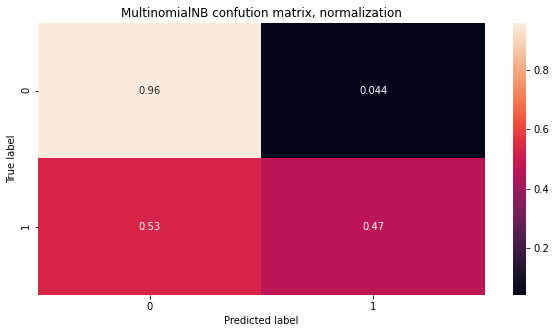

In [ ]:
y_pred_MNB = MNB.predict(X_test)
y_pred_MNB = [decode_sentiment(score) for score in y_pred_MNB]
plt.figure(figsize=(10, 5))
cf_matrix_MNB = confusion_matrix(y_test, y_pred_MNB, normalize='true')
sns.heatmap(cf_matrix_MNB, annot=True)
plt.title('MultinomialNB confution matrix, normalization')
plt.xlabel('Predicted label')
plt.ylabel('True label')

Text(69.0, 0.5, 'True label')

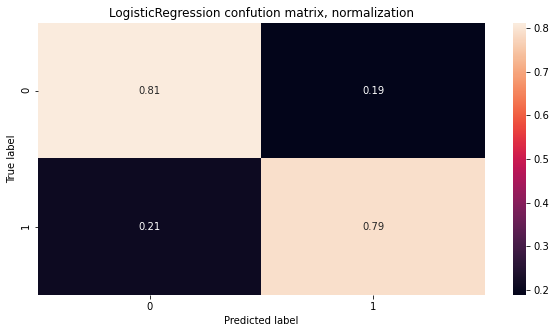

In [ ]:
y_pred_rnn = model.predict(X_test_rnn)
y_pred_rnn = [decode_sentiment(score) for score in y_pred_rnn]
plt.figure(figsize=(10, 5))
cf_matrix = confusion_matrix(y_test_rnn, y_pred_rnn, normalize='true')
sns.heatmap(cf_matrix, annot=True)
plt.title('LogisticRegression confution matrix, normalization')
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [ ]:
#save LogisticRegression model
filename_log_reg = 'log_reg_model.h5'
pickle.dump(log_reg, open(filename_log_reg, 'wb'))

#save MultinomialNB model
filename_MNB = 'MNB_model.h5'
pickle.dump(MNB, open(filename_MNB, 'wb'))

#save TfidfVectorizer
tfidf_Filename = "tfidf_Model.pkl"  
pickle.dump(tvec.vocabulary_,open(tfidf_Filename,"wb"))

#save Tokenizer
tokenizer_Filename = 'tokenizer_model.pkl'
pickle.dump(tokenizer,open(tokenizer_Filename,"wb"))

#save RNN model
model.save('keras_model.h5')
pickle.dump(tokenizer, open('tokenizer_model.pkl', "wb"), protocol=0)